# VQA - *Gan et al.* - Experimental implementation

Here, we try to simulate the experimental set up of VQA. We implement the following elements:

1. Sampling: we simulate sampling instead of computing the probability.
2. Noise: we define noisy parameters. The noise includes the discrete aspect of the control parameters and thermic noise.
3. Threshold detection: we consider that the sampling is done with threshold detection.
4. Imperfect sources: they simulate actual source imperfections and circuit losses.

## Threshold detection

We start by implementing threshold detection. As previously, we convert the number resolving detection basis into the threshold detection basis.

In [1]:
dict_convert=dict()
def threshold_convert(state):
    res=[]
    state_str=str(state)
    try:
        return dict_convert[state_str]
    except KeyError:
        state_str=state_str[1:len(state_str)-1]
        state_list=list(map(int, state_str.split(",")))
        for i in range(len(state_list)):
            if state_list[i] > 0:
                res.append(1)
            else:
                res.append(0)
        dict_convert[state_str]=res
    return res

Here, the detectors may detect nothing (i.e. $|0,0,0>$ is a possible outcome), therefore we have $2^m$ possible outcomes.

In [2]:
dict_order=dict()
def order(threshold_state):
    str_th_st=str(threshold_state)
    try:
        return dict_order[str_th_st]
    except:
        str_car="0b"
        for car in threshold_state:
            str_car = str_car + str(car)
        res=int(str_car, 2) 
        dict_order[str_th_st]=res
    return res

## Sampling

Sampling is simulated numerically by taking the threshold probabilities and drawing $\text{N_DRAW}$ values according to the aforementioned probability law. The threshold probability law is computed using the SLOS backend.

In [17]:
def noisy_prob():
    """
    Computes the noisy threshold detection probability.
    
    Input:
        s1: backend
        input_state
    """
    _, output_distribution=QPU.run(simulator_backend)
    probs=np.zeros((2**m,))
    for state, prob in output_distribution.items(): # dictionary behavior - suboptimal
        probs[order(threshold_convert(state))]+=prob
    sample=np.random.choice(np.arange(len(probs)), size=(N_DRAW,), p=probs)
    res=[]
    for i in range(len(probs)):
        res.append(np.count_nonzero(sample==i))
    return np.array(res) / np.sum(res)

## Parameters noise

The noise is represented numerically in the circuit parameters.

Parameters noise takes into account the discretization of the controlling tension and other sources of noise which we call "thermic noise".

In [4]:
N_DRAW=1000 # number of draws
step = 6.5 * 1e-3 # increment of phase control
thermic_noise=1e-3 # thermic noise (includes other sources of noise)

In [5]:
def noisy_angle(angle):
    """
    Computes the angle observed by the phase shifter due to the discretization of the input voltage.
    """
    return angle - np.remainder(angle, step)

## Initialization

In [6]:
import perceval as pcvl
import perceval.lib.symb as symb
import numpy as np
import sklearn.datasets as skdt
import matplotlib.pyplot as plt
from math import comb
import time
from copy import deepcopy
import pybobyqa
from scipy.optimize import dual_annealing
import sympy as sp
from tqdm import tqdm

In [7]:
m = 3 # number of modes
a = 1
nb_param = 18
h = .1    # step size in the mesh
alpha_value = .0001

## Circuit set up

The circuit is set up beforehand since it does not depend on the type of the considered data set.

In [8]:
def set_up_QPC():

    global simulator_backend, source
    global px, py
    global c
    global circuit_P, beam_spliters, phase_shifters
    
    # circuit definition

    px = pcvl.P("px")
    py = pcvl.P("py")

    circuit_P = np.array([pcvl.P("phi0"), pcvl.P("phi1"), pcvl.P("phi2"), pcvl.P("psi0"), pcvl.P("psi1"), pcvl.P("psi2")])
    thetas = np.array([pcvl.P("theta0"), pcvl.P("theta1"), pcvl.P("theta2"), pcvl.P("theta3"), pcvl.P("theta4"), pcvl.P("theta5")])
    ps = np.array([pcvl.P("p0"), pcvl.P("p1"), pcvl.P("p2"), pcvl.P("p3"), pcvl.P("p4"), pcvl.P("p5")])
    circuit_P = np.concatenate((circuit_P, thetas, ps))
    
    beam_spliters = []
    phase_shifters = []
    for i in range(nb_param // 6): # first generic interferometer
        r = i % 2
        beam_spliters.append(pcvl.Circuit(m=3).add((r, r + 1), symb.BS(theta=thetas[i], phi=ps[i])))
        phase_shifters.append(pcvl.Circuit(m=3).add(r, symb.PS(circuit_P[i])))
    for i in range(nb_param // 6): # second generic interferometer
        r = i % 2
        beam_spliters.append(pcvl.Circuit(m=3).add((r, r + 1), symb.BS(theta=thetas[i + nb_param // 6], phi=ps[i + nb_param // 6])))
        phase_shifters.append(pcvl.Circuit(m=3).add(r, symb.PS(circuit_P[i + nb_param // 6])))
    
    c = pcvl.Circuit(m=3)
    for i in range(nb_param // 6): # first generic interferometer
        c.add((0, 1, 2), beam_spliters[i]).add((0, 1, 2), phase_shifters[i])
    c.add(0, symb.PS(px)) # first phase shifter
    c.add(1, symb.PS(py)) # second phase shifter
    for i in range(nb_param // 6): # second generic interferometer
        c.add((0, 1, 2), beam_spliters[i + nb_param // 6]).add((0, 1, 2), phase_shifters[i + nb_param // 6])
        
        
    # backend definition

    simulator_backend = pcvl.BackendFactory().get_backend("SLOS")
    source=pcvl.Source(brightness=0.6, purity=.99)

set_up_QPC()

## Data generation

The data is generated using the ```sklearn``` module. We can define three types of data sets:

1. linear data sets: they correspond to two blobs that can be separated by a hyperplane.
2. circular data sets: they correspond to two clusters that can be separated by a sphere.
3. lunar data sets: they correspond to two interwined semi-circle clusters. The separation between the two clusters requires a more complex shape.

For the sake of making the graphical representation easier, the data is normalized so as to make it within the hyprcube $[-1, 1 ]^D$.

In [9]:
def normalizeX(z):
    """
    Values between -1 and 1
    """
    zmax = np.max(z)
    zmin = np.min(z)
    return 2 * (z - zmin) / (zmax - zmin) - 1

def normalizey(z):
    """
    Values between -1 and 1
    """
    for i in range(len(z)):
        if z[i] == 0:
            z[i] = -1
    return z

def generate_data(type, N):
    """
    generates random datasets of different types
    type == 0: linear dataset
    type == 1: circular dataset
    type == 2: moon dataset
    """
    if type == 0: # linear
        X, y = skdt.make_blobs(n_samples=N, centers=2, n_features=2, cluster_std = 1)
    elif type == 1: # circle
        X, y = skdt.make_circles(n_samples=N, noise=0.03)
    elif type == 2: # moon
        X, y = skdt.make_moons(n_samples=N, noise=0.2)
    else:
        raise(ValueError("Invalid value of type. Enter help(generate_data)"))

    # data normalization
    X = normalizeX(X)
    y = normalizey(y)
    return X, y

## Loss function

As proposed by <a href="https://arxiv.org/abs/2107.05224v1">Gan et al</a>, we use the following loss function:

\begin{equation*}
    \mathcal{L}(\Theta, \lambda) = \frac{1}{2 N} \ \sum_{i = 1}^{N} (y_i - \text{sgn}[f(x_i, \Theta, \lambda)])^2 + \alpha \ \lambda.\lambda
\end{equation*}

In [10]:
def computation_loss(parameters):
    """
    Computes the loss function corrersponding to parameters
    """
    global X_quant, y_quant
    global circuit_P
    global c

    loss = 0
    
    # set new circuit parameters with noise
    for j in range(nb_param):
        circuit_P[j].set_value(np.random.normal(noisy_angle(parameters[j]), scale=thermic_noise))
 
    for i in tqdm(range(len(X_quant))):  
        px.set_value(np.random.normal(noisy_angle(X_quant[i,0]), scale=thermic_noise))
        py.set_value(np.random.normal(noisy_angle(X_quant[i,1]), scale=thermic_noise))
        fvalue = np.sign(np.sum(np.multiply(noisy_prob(), parameters[nb_param:])))
        loss += np.linalg.norm(fvalue - y_quant[i])**2
            
    loss /= (2 * len(X_quant))
    loss += alpha_value * np.linalg.norm(parameters[nb_param:])**2   # regularization of the loss value
    print("loss:",loss)
    loss_list.append(loss)
    return loss

## Training

Through trial and error, we arrived to the conclusion that the best minimization algorithm is ```scipy.optimize.dual_annealing```. Gradient descent does not work in general because the function is strongly non-convex since our parameterization is not natural for our problem.

In [38]:
def training():
    
    """
    Defines the training process which depend on the global value of n (since it defines the data set type).
    """
    
    def test(n):
        if n == 1:
            return 1e-3
        elif n == 6:
            return .5
        elif n == 3:
            return .3
        
    def maxeval(n):
        if n == 1:
            return 75
        elif n == 6:
            return 500
        elif n == 3:
            return 250
    
    global loss_list
    global X_quant, y_quant
    global input_state
    global parameters
    
    loss_list=[]
    res=dual_annealing(computation_loss, [(0, 2 * np.pi)] * nb_param + [(-a, a)] * (2**m),
                  maxfun=maxeval(n), no_local_search=True, callback=lambda x,f,content: f < test(n))
    parameters = res.x

## Scoring

We define the score as usual in ML. However, we add the fact that the input points may be modified in the following manner:

\begin{equation*}
x' = \alpha_x (x - \beta_x)
\end{equation*}

\begin{equation*}
y' = \alpha_y (y - \beta_y)
\end{equation*}

where $\alpha_x$, $\beta_x$, $\alpha_y$ and $\beta_y$ are defined in the vector ```scale```.

This approach will be useful in the training of the hyper-parameters $\alpha_x$, $\beta_x$, $\alpha_y$ and $\beta_y$.

In [12]:
def scoring(X, y, scale):
    """
    Computes the score of the circuit on the test set (X, y) using the current value of the global variable parameters
    and the value of scale
    """
    cpt = 0
    for j in range(nb_param):
        circuit_P[j].set_value(np.random.normal(noisy_angle(parameters[j]), scale=thermic_noise))
    for i in range(len(X)):
        px.set_value(np.random.normal(noisy_angle(scale[0] * (X[i,0] - scale[2])), scale=thermic_noise))
        py.set_value(np.random.normal(noisy_angle(scale[1] * (X[i,1] - scale[3])), scale=thermic_noise))
        fvalue = np.sign(np.sum(np.multiply(noisy_prob(), parameters[nb_param:])))
        if fvalue == y[i]:
            cpt += 1
    return cpt / len(X)

## Training of hyper-parameters

Once the circuit is trained (i.e. the minimization is over), we try as a last attempt to improve the classification. We apply the following space transformation:

\begin{equation*}
x' = \alpha_x (x - \beta_x)
\end{equation*}

\begin{equation*}
y' = \alpha_y (y - \beta_y)
\end{equation*}

where $\alpha_x$, $\beta_x$, $\alpha_y$ and $\beta_y$ are our hyper-parameters.

Starting from the initial values $ (\alpha_x, \beta_x, \alpha_y \beta_y) = (1, 0, 1, 0)$, we try to maximize *locally* the score function using the Python function ```pybobyqa.solve```.

In [13]:
def hyper_train(X, y):
    def function(scale):
        return - scoring(X, y, scale)
    score = 0
    scale = [1, 1, 0, 0]  # start by the default parameteres
    return pybobyqa.solve(function, scale, print_progress=True).x
    # we just want to slightly improve the quality of the result. We are already there

## Graphical representation

In [14]:
def plot_quantum_fitting(X, y, ret, scale):

    for j in range(nb_param):
        circuit_P[j].set_value(np.random.normal(noisy_angle(parameters[j]), scale=thermic_noise))

    # Generate figure
    plt.figure(figsize=(8,8))

    # create a mesh for the background

    xx = np.arange(-2, 2, h)
    yy = np.arange(-2, 2, h)
    zs = np.zeros((len(xx), len(yy)))
    for i in range(len(xx)):
        for j in range(len(yy)):
            px.set_value(np.random.normal(noisy_angle(scale[0] * (xx[i] - scale[2])), scale=thermic_noise))
            py.set_value(np.random.normal(noisy_angle(scale[1] * (yy[j] - scale[3])), scale=thermic_noise))
            zs[i, j] = np.sign(np.sum(np.multiply(noisy_prob(), parameters[nb_param:])))
    cs = plt.contourf(xx, yy, zs, cmap=plt.cm.coolwarm)
    plt.colorbar(cs)

    # Plot scatter points
    plt.scatter(
        X[y == -1, 1],
        X[y == -1, 0],
        s=4,
        label='-1',
        alpha=1, c = ["#0cf9f1"]
    )
    plt.scatter(
        X[y == 1, 1],
        X[y == 1, 0],
        s=4,
        label='1',
        alpha=1,
        c = ["#790909"]
    )

    plt.xlabel('x', fontsize=18)
    plt.ylabel('y', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    lgnd = plt.legend(fontsize=18)

    plt.xlim(-2, 2)
    plt.ylim(-2,2)
    for it in range(2):
        lgnd.legendHandles[it]._sizes = [40]
    plt.title("score = " + str(ret))
    plt.show()

## Wrapper

This wrapper calls the functions defined above. It starts by redefining the key value of $n$ and the Perceval ```Processor``` and the different source set ups. Afterwards, it generates a normalized data set. The data set is divided into training, hyper-training and testing sets.

The wrapper trains the parameters of the circuit on the training sets. It trains the hyper-parameters on the hyper-training set. Finally, it computes the score and plots the graphical representation using the testing set.

In [28]:
def q_fit(type, N = 1000):
    """
    a wrapper that computes a random quantum fitting process
    type == 0: linear dataset
    type == 1: circular dataset
    type == 2: moon dataset
    """
    global n, QPU
    
    if type == 0:
        n = 1
        QPU=pcvl.Processor({0:source}, c)
    elif type == 1:
        n=6
        QPU=pcvl.Processor({0:source, 1:source, 2:source}, c)
    elif type == 2:
        n = 3
        QPU=pcvl.Processor({0:source, 1:source, 2:source}, c)
        
    print(">>> Source distrbution")
    pcvl.pdisplay(QPU.source_distribution)
    
    begin = time.time()
    global X_quant, y_quant
    X, y = generate_data(type, N)  # data generation
    prop1 = int(0.8 * len(y))
    prop2 = int(0.9 * len(y))
    X_quant = X[:prop1]
    y_quant = y[:prop1]
    training()  # train lambda
    scale = hyper_train(X[prop1:prop2], y[prop1:prop2])  # train the hyperparameters
    print("\n>>>>>> scale = ", scale) # print the best scale
    ret = scoring(X[prop2:], y[prop2:], scale) # compute the score on a new dataset
    print("\n>>>>>> score = ", ret)
    plot_quantum_fitting(X[prop2:], y[prop2:], ret, scale) # plot the results for the new dataset
    print("time : ", time.time() - begin)

## Examples

Below, we present some examples of VQA classification. We use the list ```loss_list``` in order to save the evolution of the loss value during the dual annealing process.

The resuts below show that adding noise, imperfect sources and sampling do not influence the quality of the classification. They only lead to blurred borders between the classes.

However, threshold detection decreases the quality of the fitting. On the one hand, it decreases the size of the output space. On the other hand, it transforms a large number of outputs into the same output. This leads of course to erasing data, hence a lower quality classification.

Moreover, the code is much slower than the ideal case. This is due to the fact that ```SVDistribution``` elements behave like dictionaries and not ```numpy.array```. Consequently, the optimization is harder.

### Linear data set

For linear data set classification, we use one source at the first mode.

Since we only use one photon for linear data set classification, number resolving and threshold detection are the same. Nevertheless, threshold detection may play a role in the case of the emission of two photons.

>>> Source distrbution


state,probability
"|1,0,0>",0.594
"|0,0,0>",2/5
"|2,0,0>",0.006


100%|██████████| 800/800 [00:01<00:00, 506.70it/s]


loss: 1.035314202328515


100%|██████████| 800/800 [00:01<00:00, 504.77it/s]


loss: 1.0351956738745283


100%|██████████| 800/800 [00:01<00:00, 508.10it/s]


loss: 1.0352424645538436


100%|██████████| 800/800 [00:01<00:00, 508.46it/s]


loss: 1.0352361593210635


100%|██████████| 800/800 [00:01<00:00, 504.69it/s]


loss: 1.0504193437707399


100%|██████████| 800/800 [00:01<00:00, 501.47it/s]


loss: 1.035182283998126


100%|██████████| 800/800 [00:01<00:00, 503.23it/s]


loss: 0.965141481797048


100%|██████████| 800/800 [00:01<00:00, 504.20it/s]


loss: 1.035282210505048


100%|██████████| 800/800 [00:01<00:00, 502.32it/s]


loss: 1.0353783647040724


100%|██████████| 800/800 [00:01<00:00, 502.24it/s]


loss: 1.42277686160346


100%|██████████| 800/800 [00:01<00:00, 505.15it/s]


loss: 0.9651537161054593


100%|██████████| 800/800 [00:01<00:00, 496.25it/s]


loss: 0.9377879804675692


100%|██████████| 800/800 [00:01<00:00, 505.10it/s]


loss: 1.035228176634027


100%|██████████| 800/800 [00:01<00:00, 504.73it/s]


loss: 0.9652263183945933


100%|██████████| 800/800 [00:01<00:00, 506.20it/s]


loss: 0.9651793174680783


100%|██████████| 800/800 [00:01<00:00, 502.79it/s]


loss: 1.0353593085136903


100%|██████████| 800/800 [00:01<00:00, 500.76it/s]


loss: 1.0352060023556886


100%|██████████| 800/800 [00:01<00:00, 482.93it/s]


loss: 1.0351870413636837


100%|██████████| 800/800 [00:01<00:00, 509.36it/s]


loss: 1.7303354143253387


100%|██████████| 800/800 [00:01<00:00, 510.34it/s]


loss: 0.9652350825344289


100%|██████████| 800/800 [00:01<00:00, 507.78it/s]


loss: 0.9652732126520301


100%|██████████| 800/800 [00:01<00:00, 507.49it/s]


loss: 0.9651470739602418


100%|██████████| 800/800 [00:01<00:00, 510.63it/s]


loss: 1.0353722548311124


100%|██████████| 800/800 [00:01<00:00, 509.84it/s]


loss: 0.9652513316577872


100%|██████████| 800/800 [00:01<00:00, 510.62it/s]


loss: 1.0351744638202194


100%|██████████| 800/800 [00:01<00:00, 508.71it/s]


loss: 0.9652344857431799


100%|██████████| 800/800 [00:01<00:00, 511.19it/s]


loss: 0.9652266451139019


100%|██████████| 800/800 [00:01<00:00, 507.87it/s]


loss: 0.9652266451139019


100%|██████████| 800/800 [00:01<00:00, 505.88it/s]


loss: 0.9652266451139019


100%|██████████| 800/800 [00:01<00:00, 509.47it/s]


loss: 0.9652266451139019


100%|██████████| 800/800 [00:01<00:00, 506.78it/s]


loss: 0.9652266451139019


100%|██████████| 800/800 [00:01<00:00, 509.87it/s]


loss: 0.9652266451139019


100%|██████████| 800/800 [00:01<00:00, 506.16it/s]


loss: 0.9652266451139019


100%|██████████| 800/800 [00:01<00:00, 509.69it/s]


loss: 0.9652266451139019


100%|██████████| 800/800 [00:01<00:00, 506.99it/s]


loss: 0.0002266451139019338
 Run  Iter     Obj       Grad     Delta      rho     Evals 
  1     1   -1.00e+00  0.00e+00  1.00e-01  1.00e-01    9   
  1     2   -1.00e+00  0.00e+00  5.00e-02  1.00e-02    9   
  1     3   -1.00e+00  0.00e+00  1.50e-02  1.00e-02   10   
  1     4   -1.00e+00  0.00e+00  1.50e-02  1.00e-02   11   
  1     5   -1.00e+00  0.00e+00  5.00e-03  1.00e-03   11   
  1     6   -1.00e+00  0.00e+00  1.50e-03  1.00e-03   12   
  1     7   -1.00e+00  0.00e+00  1.50e-03  1.00e-03   13   
  1     8   -1.00e+00  0.00e+00  5.00e-04  1.00e-04   13   
  1     9   -1.00e+00  0.00e+00  1.50e-04  1.00e-04   14   
  1    10   -1.00e+00  0.00e+00  1.50e-04  1.00e-04   15   
  1    11   -1.00e+00  0.00e+00  5.00e-05  1.00e-05   15   
  1    12   -1.00e+00  0.00e+00  1.50e-05  1.00e-05   16   
  1    13   -1.00e+00  0.00e+00  1.50e-05  1.00e-05   17   
  1    14   -1.00e+00  0.00e+00  5.00e-06  1.00e-06   17   
  1    15   -1.00e+00  0.00e+00  1.50e-06  1.00e-06   18   
  1    16   

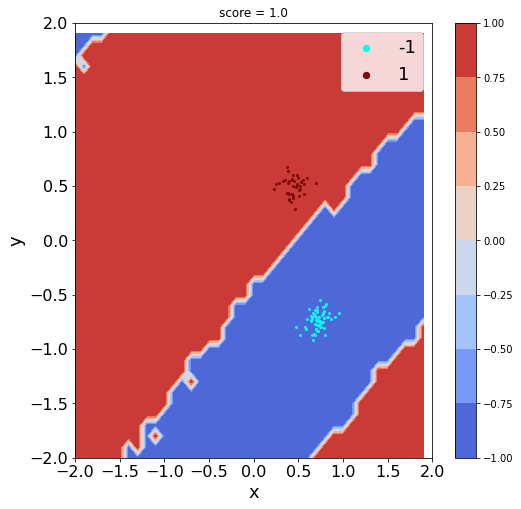

time :  63.68840956687927


In [24]:
N_DRAW=1000
q_fit(0, 1000)

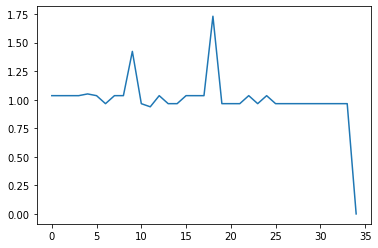

In [25]:
plt.plot([i for i in range(len(loss_list))], loss_list)

### Circular data set

Circular classification requires $6$ photons since circular models require more expressivity for VQA. However, we use a $3$-mode circuit. Accordingly, the expressivity of our circuit decreases dramatically due to threshold detection.

>>> Source distrbution


state,probability
"|1,1,1>",0.209585
"|0,1,1>",0.141134
"|1,0,1>",0.141134
"|1,1,0>",0.141134
"|0,0,1>",0.09504
"|0,1,0>",0.09504
"|1,0,0>",0.09504
"|0,0,0>",0.064
"|1,1,2>",0.002117
"|2,1,1>",0.002117


100%|██████████| 800/800 [00:22<00:00, 35.72it/s]


loss: 0.990297795808326


100%|██████████| 800/800 [00:22<00:00, 35.56it/s]


loss: 1.0103227153900312


100%|██████████| 800/800 [00:22<00:00, 35.88it/s]


loss: 1.0102517477672766


100%|██████████| 800/800 [00:22<00:00, 36.02it/s]


loss: 0.9903331394497839


100%|██████████| 800/800 [00:22<00:00, 36.16it/s]


loss: 0.9902796326220451


100%|██████████| 800/800 [00:22<00:00, 35.70it/s]


loss: 1.0101910660314495


100%|██████████| 800/800 [00:22<00:00, 35.68it/s]


loss: 0.9703294507268884


100%|██████████| 800/800 [00:22<00:00, 36.26it/s]


loss: 1.0103301632095314


100%|██████████| 800/800 [00:22<00:00, 36.29it/s]


loss: 0.9951865092458905


100%|██████████| 800/800 [00:21<00:00, 36.53it/s]


loss: 0.9902390731436197


100%|██████████| 800/800 [00:21<00:00, 36.82it/s]


loss: 1.0101675679793252


100%|██████████| 800/800 [00:21<00:00, 36.80it/s]


loss: 0.9976733354893866


100%|██████████| 800/800 [00:21<00:00, 36.51it/s]


loss: 0.9902758576679453


100%|██████████| 800/800 [00:21<00:00, 36.76it/s]


loss: 1.0102346228899797


100%|██████████| 800/800 [00:21<00:00, 36.80it/s]


loss: 0.9901313525106785


100%|██████████| 800/800 [00:21<00:00, 36.69it/s]


loss: 1.0102173210077348


100%|██████████| 800/800 [00:21<00:00, 37.12it/s]


loss: 0.9802090682563007


100%|██████████| 800/800 [00:21<00:00, 36.62it/s]


loss: 0.9477377752579728


100%|██████████| 800/800 [00:21<00:00, 36.99it/s]


loss: 1.0252795191631687


100%|██████████| 800/800 [00:21<00:00, 36.60it/s]


loss: 0.9903093822933597


100%|██████████| 800/800 [00:22<00:00, 36.16it/s]


loss: 1.0576756206074887


100%|██████████| 800/800 [00:21<00:00, 36.77it/s]


loss: 1.0101286316966132


100%|██████████| 800/800 [00:21<00:00, 37.16it/s]


loss: 0.9277489216467586


100%|██████████| 800/800 [00:21<00:00, 36.97it/s]


loss: 1.1401247380976451


100%|██████████| 800/800 [00:21<00:00, 37.39it/s]


loss: 1.0101639824582114


100%|██████████| 800/800 [00:22<00:00, 36.07it/s]


loss: 1.0101373768019992


100%|██████████| 800/800 [00:22<00:00, 36.16it/s]


loss: 1.007941301296525


100%|██████████| 800/800 [00:21<00:00, 36.53it/s]


loss: 0.997941301296525


100%|██████████| 800/800 [00:21<00:00, 36.93it/s]


loss: 0.990441301296525


100%|██████████| 800/800 [00:21<00:00, 36.96it/s]


loss: 1.075441301296525


100%|██████████| 800/800 [00:21<00:00, 37.37it/s]


loss: 0.990441301296525


100%|██████████| 800/800 [00:21<00:00, 36.85it/s]


loss: 0.990441301296525


100%|██████████| 800/800 [00:22<00:00, 36.36it/s]


loss: 0.990441301296525


100%|██████████| 800/800 [00:22<00:00, 36.15it/s]


loss: 0.990441301296525


100%|██████████| 800/800 [00:22<00:00, 36.04it/s]


loss: 0.990441301296525


100%|██████████| 800/800 [00:21<00:00, 36.43it/s]


loss: 1.062941301296525


100%|██████████| 800/800 [00:22<00:00, 36.21it/s]


loss: 1.002941301296525


100%|██████████| 800/800 [00:21<00:00, 36.55it/s]


loss: 1.002941301296525


100%|██████████| 800/800 [00:21<00:00, 36.78it/s]


loss: 0.980441301296525


100%|██████████| 800/800 [00:21<00:00, 36.41it/s]


loss: 0.992941301296525


100%|██████████| 800/800 [00:22<00:00, 36.14it/s]


loss: 0.990441301296525


100%|██████████| 800/800 [00:22<00:00, 36.27it/s]


loss: 0.990441301296525


100%|██████████| 800/800 [00:21<00:00, 36.41it/s]


loss: 0.967941301296525


100%|██████████| 800/800 [00:21<00:00, 36.42it/s]


loss: 1.007941301296525


100%|██████████| 800/800 [00:21<00:00, 36.41it/s]


loss: 1.100441301296525


100%|██████████| 800/800 [00:22<00:00, 35.94it/s]


loss: 1.1154807623090826


100%|██████████| 800/800 [00:22<00:00, 36.10it/s]


loss: 1.167967618893239


100%|██████████| 800/800 [00:22<00:00, 35.38it/s]


loss: 1.0578767457163285


100%|██████████| 800/800 [00:22<00:00, 36.25it/s]


loss: 0.9902830719232149


100%|██████████| 800/800 [00:21<00:00, 36.37it/s]


loss: 0.9902823990633515


100%|██████████| 800/800 [00:22<00:00, 36.31it/s]


loss: 1.0502199172829838


100%|██████████| 800/800 [00:21<00:00, 36.52it/s]


loss: 1.0102013902073552


100%|██████████| 800/800 [00:21<00:00, 36.52it/s]


loss: 1.010144992953542


100%|██████████| 800/800 [00:21<00:00, 36.61it/s]


loss: 0.9902051579339141


100%|██████████| 800/800 [00:21<00:00, 36.69it/s]


loss: 0.9901234222743431


100%|██████████| 800/800 [00:21<00:00, 36.65it/s]


loss: 0.9951915959161236


100%|██████████| 800/800 [00:22<00:00, 36.09it/s]


loss: 1.1653116117543976


100%|██████████| 800/800 [00:22<00:00, 36.27it/s]


loss: 1.0103180427674774


100%|██████████| 800/800 [00:22<00:00, 36.31it/s]


loss: 0.99022314613385


100%|██████████| 800/800 [00:22<00:00, 36.16it/s]


loss: 1.010249612438707


100%|██████████| 800/800 [00:22<00:00, 35.55it/s]


loss: 0.9903396848048008


100%|██████████| 800/800 [00:22<00:00, 35.71it/s]


loss: 0.9903817611536698


100%|██████████| 800/800 [00:21<00:00, 36.72it/s]


loss: 1.0103634364702758


100%|██████████| 800/800 [00:21<00:00, 36.42it/s]


loss: 0.9902346149597344


100%|██████████| 800/800 [00:21<00:00, 36.50it/s]


loss: 0.9901570967741146


100%|██████████| 800/800 [00:21<00:00, 36.69it/s]


loss: 1.0451317174232835


100%|██████████| 800/800 [00:21<00:00, 36.83it/s]


loss: 0.9901402462024115


100%|██████████| 800/800 [00:22<00:00, 36.27it/s]


loss: 0.990262420350783


100%|██████████| 800/800 [00:21<00:00, 36.63it/s]


loss: 1.0102432999941808


100%|██████████| 800/800 [00:21<00:00, 36.41it/s]


loss: 1.0103343525245523


100%|██████████| 800/800 [00:21<00:00, 36.69it/s]


loss: 1.0102896784735325


100%|██████████| 800/800 [00:21<00:00, 36.54it/s]


loss: 1.0101408812544752


100%|██████████| 800/800 [00:22<00:00, 36.19it/s]


loss: 1.0127143998687722


100%|██████████| 800/800 [00:21<00:00, 36.40it/s]


loss: 0.9476357604878677


100%|██████████| 800/800 [00:22<00:00, 35.39it/s]


loss: 1.0326285959864405


100%|██████████| 800/800 [00:21<00:00, 36.42it/s]


loss: 0.9902696290679419


100%|██████████| 800/800 [00:22<00:00, 36.34it/s]


loss: 1.0101735857262766


100%|██████████| 800/800 [00:21<00:00, 36.42it/s]


loss: 0.9902333113367312


100%|██████████| 800/800 [00:22<00:00, 36.25it/s]


loss: 0.9903906768805502


100%|██████████| 800/800 [00:21<00:00, 36.52it/s]


loss: 0.9903906768805502


100%|██████████| 800/800 [00:22<00:00, 35.85it/s]


loss: 0.9903906768805502


100%|██████████| 800/800 [00:21<00:00, 36.37it/s]


loss: 0.9903906768805502


100%|██████████| 800/800 [00:21<00:00, 36.74it/s]


loss: 0.9878906768805502


100%|██████████| 800/800 [00:21<00:00, 36.43it/s]


loss: 1.0178906768805502


100%|██████████| 800/800 [00:22<00:00, 36.22it/s]


loss: 1.0078906768805502


100%|██████████| 800/800 [00:22<00:00, 36.22it/s]


loss: 0.9903906768805502


100%|██████████| 800/800 [00:21<00:00, 37.17it/s]


loss: 0.7478906768805502


100%|██████████| 800/800 [00:21<00:00, 36.42it/s]


loss: 0.8853906768805502


100%|██████████| 800/800 [00:21<00:00, 37.29it/s]


loss: 0.9903906768805502


100%|██████████| 800/800 [00:21<00:00, 37.16it/s]


loss: 0.9903906768805502


100%|██████████| 800/800 [00:21<00:00, 37.42it/s]


loss: 0.9903906768805502


100%|██████████| 800/800 [00:21<00:00, 37.18it/s]


loss: 0.9903906768805502


100%|██████████| 800/800 [00:21<00:00, 37.27it/s]


loss: 0.9903906768805502


100%|██████████| 800/800 [00:21<00:00, 37.28it/s]


loss: 0.9603906768805501


100%|██████████| 800/800 [00:21<00:00, 37.10it/s]


loss: 0.9453906768805501


100%|██████████| 800/800 [00:21<00:00, 37.39it/s]


loss: 1.04539067688055


100%|██████████| 800/800 [00:21<00:00, 37.15it/s]


loss: 1.0328906768805501


100%|██████████| 800/800 [00:21<00:00, 37.25it/s]


loss: 0.9979273324367873


100%|██████████| 800/800 [00:21<00:00, 37.01it/s]


loss: 0.9904549055575134


100%|██████████| 800/800 [00:21<00:00, 36.61it/s]


loss: 0.9904502057468574


100%|██████████| 800/800 [00:22<00:00, 36.26it/s]


loss: 1.0103511817577098


100%|██████████| 800/800 [00:22<00:00, 36.08it/s]


loss: 0.9503756955950462


100%|██████████| 800/800 [00:22<00:00, 35.16it/s]


loss: 0.96787690795943


100%|██████████| 800/800 [00:23<00:00, 34.70it/s]


loss: 0.8229017838809867


100%|██████████| 800/800 [00:23<00:00, 34.58it/s]


loss: 0.9903581279320718


100%|██████████| 800/800 [00:23<00:00, 34.54it/s]


loss: 1.0102672678234697


100%|██████████| 800/800 [00:26<00:00, 29.70it/s]


loss: 1.0102898827548898


100%|██████████| 800/800 [00:39<00:00, 20.08it/s]


loss: 1.0102615076045358


100%|██████████| 800/800 [00:29<00:00, 27.12it/s]


loss: 1.0103219134081385


100%|██████████| 800/800 [00:22<00:00, 35.60it/s]


loss: 0.9902789858276438


100%|██████████| 800/800 [00:22<00:00, 36.15it/s]


loss: 1.0102205590092876


100%|██████████| 800/800 [00:22<00:00, 35.99it/s]


loss: 0.9903052147734158


100%|██████████| 800/800 [00:22<00:00, 35.18it/s]


loss: 0.8852358559860447


100%|██████████| 800/800 [00:21<00:00, 36.52it/s]


loss: 0.9902855055629073


100%|██████████| 800/800 [00:21<00:00, 36.47it/s]


loss: 0.9902709472219436


100%|██████████| 800/800 [00:21<00:00, 36.89it/s]


loss: 0.9626511518917034


100%|██████████| 800/800 [00:21<00:00, 36.97it/s]


loss: 0.9903491208332263


100%|██████████| 800/800 [00:22<00:00, 35.45it/s]


loss: 1.0103597375616225


100%|██████████| 800/800 [00:22<00:00, 35.09it/s]


loss: 1.0002649686036973


100%|██████████| 800/800 [00:22<00:00, 36.14it/s]


loss: 1.0102869406938118


100%|██████████| 800/800 [00:22<00:00, 35.89it/s]


loss: 1.0877265633848172


100%|██████████| 800/800 [00:22<00:00, 36.13it/s]


loss: 1.015182159701217


100%|██████████| 800/800 [00:22<00:00, 36.22it/s]


loss: 1.012779685253536


100%|██████████| 800/800 [00:22<00:00, 36.33it/s]


loss: 1.1778090117491076


100%|██████████| 800/800 [00:22<00:00, 36.25it/s]


loss: 1.0101791776626194


100%|██████████| 800/800 [00:22<00:00, 36.05it/s]


loss: 0.8451279429909289


100%|██████████| 800/800 [00:21<00:00, 36.51it/s]


loss: 1.0102997849726378


100%|██████████| 800/800 [00:22<00:00, 35.27it/s]


loss: 0.990251881018917


100%|██████████| 800/800 [00:22<00:00, 36.25it/s]


loss: 0.9902095394691909


100%|██████████| 800/800 [00:21<00:00, 36.38it/s]


loss: 0.9904234048360363


100%|██████████| 800/800 [00:21<00:00, 36.55it/s]


loss: 0.9902421101745388


100%|██████████| 800/800 [00:22<00:00, 34.88it/s]


loss: 0.9902421101745388


100%|██████████| 800/800 [00:22<00:00, 34.97it/s]


loss: 0.9902421101745388


100%|██████████| 800/800 [00:21<00:00, 36.48it/s]


loss: 0.9902421101745388


100%|██████████| 800/800 [00:21<00:00, 38.03it/s]


loss: 0.9902421101745388


100%|██████████| 800/800 [00:21<00:00, 38.04it/s]


loss: 0.9902421101745388


100%|██████████| 800/800 [00:21<00:00, 37.82it/s]


loss: 0.9902421101745388


100%|██████████| 800/800 [00:21<00:00, 36.74it/s]


loss: 0.9902421101745388


100%|██████████| 800/800 [00:22<00:00, 36.24it/s]


loss: 0.9902421101745388


100%|██████████| 800/800 [00:21<00:00, 36.40it/s]


loss: 0.9902421101745388


100%|██████████| 800/800 [00:22<00:00, 35.04it/s]


loss: 0.9902421101745388


100%|██████████| 800/800 [00:22<00:00, 35.66it/s]


loss: 0.9902421101745388


100%|██████████| 800/800 [00:21<00:00, 36.51it/s]


loss: 0.9902421101745388


100%|██████████| 800/800 [00:21<00:00, 36.72it/s]


loss: 0.9902421101745388


100%|██████████| 800/800 [00:22<00:00, 36.09it/s]


loss: 0.9902421101745388


100%|██████████| 800/800 [00:22<00:00, 35.84it/s]


loss: 0.9902421101745388


100%|██████████| 800/800 [00:21<00:00, 36.37it/s]


loss: 0.9902421101745388


100%|██████████| 800/800 [00:22<00:00, 36.09it/s]


loss: 0.9902421101745388


100%|██████████| 800/800 [00:21<00:00, 36.37it/s]


loss: 0.9902421101745388


100%|██████████| 800/800 [00:22<00:00, 36.22it/s]


loss: 0.9902447751902569


100%|██████████| 800/800 [00:22<00:00, 35.84it/s]


loss: 0.99026931883653


100%|██████████| 800/800 [00:21<00:00, 36.83it/s]


loss: 0.9902738501860772


100%|██████████| 800/800 [00:22<00:00, 36.36it/s]


loss: 1.072738701163137


100%|██████████| 800/800 [00:21<00:00, 36.39it/s]


loss: 1.010257612600414


100%|██████████| 800/800 [00:22<00:00, 35.11it/s]


loss: 1.0102786406432018


100%|██████████| 800/800 [00:22<00:00, 35.39it/s]


loss: 1.0102969774287232


100%|██████████| 800/800 [00:21<00:00, 36.45it/s]


loss: 1.0103023161958835


100%|██████████| 800/800 [00:21<00:00, 36.44it/s]


loss: 0.9900546424890653


100%|██████████| 800/800 [00:22<00:00, 36.32it/s]


loss: 0.9900964908715726


100%|██████████| 800/800 [00:22<00:00, 35.93it/s]


loss: 1.010219171375558


100%|██████████| 800/800 [00:21<00:00, 36.46it/s]


loss: 1.0102556781874081


100%|██████████| 800/800 [00:21<00:00, 36.53it/s]


loss: 1.0102755548267748


100%|██████████| 800/800 [00:21<00:00, 36.88it/s]


loss: 1.0053481201246068


100%|██████████| 800/800 [00:21<00:00, 36.39it/s]


loss: 1.0101741213253599


100%|██████████| 800/800 [00:21<00:00, 36.58it/s]


loss: 0.9903245870084088


100%|██████████| 800/800 [00:21<00:00, 36.59it/s]


loss: 0.9903244684758079


100%|██████████| 800/800 [00:22<00:00, 35.95it/s]


loss: 1.1827612210609866


100%|██████████| 800/800 [00:21<00:00, 36.54it/s]


loss: 0.9626736283830651


100%|██████████| 800/800 [00:22<00:00, 35.10it/s]


loss: 1.0101930905319867


100%|██████████| 800/800 [00:22<00:00, 36.04it/s]


loss: 1.0103487190391724


100%|██████████| 800/800 [00:21<00:00, 36.70it/s]


loss: 0.9902554710163048


100%|██████████| 800/800 [00:21<00:00, 36.42it/s]


loss: 0.990244717095109


100%|██████████| 800/800 [00:23<00:00, 34.77it/s]


loss: 1.010263389663191


100%|██████████| 800/800 [00:23<00:00, 34.53it/s]


loss: 1.010341753843994


100%|██████████| 800/800 [00:23<00:00, 34.69it/s]


loss: 1.0103279966815688


100%|██████████| 800/800 [00:22<00:00, 36.19it/s]


loss: 1.0004025393867768


100%|██████████| 800/800 [00:21<00:00, 36.97it/s]


loss: 1.0101526593629548


100%|██████████| 800/800 [00:22<00:00, 35.58it/s]


loss: 0.9902168945015201


100%|██████████| 800/800 [00:23<00:00, 34.73it/s]


loss: 0.9901618257515773


100%|██████████| 800/800 [00:21<00:00, 37.12it/s]


loss: 1.0278670119404407


100%|██████████| 800/800 [00:21<00:00, 37.89it/s]


loss: 0.9902224036948399


100%|██████████| 800/800 [00:21<00:00, 37.23it/s]


loss: 0.9901933722238606


100%|██████████| 800/800 [00:22<00:00, 35.75it/s]


loss: 0.9903180255859463


100%|██████████| 800/800 [00:23<00:00, 34.62it/s]


loss: 0.9903180255859463


100%|██████████| 800/800 [00:23<00:00, 34.51it/s]


loss: 0.9903180255859463


100%|██████████| 800/800 [00:23<00:00, 34.55it/s]


loss: 0.9903180255859463


100%|██████████| 800/800 [00:23<00:00, 34.65it/s]


loss: 0.9903180255859463


100%|██████████| 800/800 [00:23<00:00, 34.36it/s]


loss: 0.9903180255859463


100%|██████████| 800/800 [00:23<00:00, 34.59it/s]


loss: 0.9903180255859463


100%|██████████| 800/800 [00:23<00:00, 34.48it/s]


loss: 0.9903180255859463


100%|██████████| 800/800 [00:23<00:00, 34.53it/s]


loss: 0.9903180255859463


100%|██████████| 800/800 [00:22<00:00, 36.18it/s]


loss: 0.9903180255859463


100%|██████████| 800/800 [00:22<00:00, 36.32it/s]


loss: 0.9903180255859463


100%|██████████| 800/800 [00:22<00:00, 36.18it/s]


loss: 0.9903180255859463


100%|██████████| 800/800 [00:22<00:00, 36.01it/s]


loss: 0.9903180255859463


100%|██████████| 800/800 [00:22<00:00, 35.27it/s]


loss: 0.9903180255859463


100%|██████████| 800/800 [00:22<00:00, 36.23it/s]


loss: 0.9903180255859463


100%|██████████| 800/800 [00:22<00:00, 36.30it/s]


loss: 0.9903180255859463


100%|██████████| 800/800 [00:21<00:00, 36.48it/s]


loss: 0.9903180255859463


100%|██████████| 800/800 [00:21<00:00, 36.48it/s]


loss: 0.9903180255859463


100%|██████████| 800/800 [00:21<00:00, 36.45it/s]


loss: 0.9903180255859463


100%|██████████| 800/800 [00:22<00:00, 36.15it/s]


loss: 0.9903249238932946


100%|██████████| 800/800 [00:21<00:00, 36.57it/s]


loss: 0.9903327527188396


100%|██████████| 800/800 [00:21<00:00, 36.50it/s]


loss: 0.9903104964157314


100%|██████████| 800/800 [00:22<00:00, 35.02it/s]


loss: 0.9902970086212234


100%|██████████| 800/800 [00:23<00:00, 34.69it/s]


loss: 0.9903387653001814


100%|██████████| 800/800 [00:22<00:00, 35.66it/s]


loss: 0.990303446046117


100%|██████████| 800/800 [00:22<00:00, 36.05it/s]


loss: 1.1477463341262713


100%|██████████| 800/800 [00:22<00:00, 34.84it/s]


loss: 1.1502505730753543


100%|██████████| 800/800 [00:22<00:00, 36.05it/s]


loss: 1.0103954540231277


100%|██████████| 800/800 [00:22<00:00, 36.32it/s]


loss: 0.9901735875914975


100%|██████████| 800/800 [00:22<00:00, 36.13it/s]


loss: 0.9903475728722634


100%|██████████| 800/800 [00:22<00:00, 35.77it/s]


loss: 0.9902495250335038


100%|██████████| 800/800 [00:22<00:00, 35.86it/s]


loss: 1.0377422945971773


100%|██████████| 800/800 [00:22<00:00, 36.32it/s]


loss: 1.010223301184699


100%|██████████| 800/800 [00:23<00:00, 34.63it/s]


loss: 1.0103248189060299


100%|██████████| 800/800 [00:23<00:00, 34.29it/s]


loss: 0.9902427111181857


100%|██████████| 800/800 [00:23<00:00, 34.25it/s]


loss: 0.9903167217201245


100%|██████████| 800/800 [00:23<00:00, 34.50it/s]


loss: 0.9904049517692411


100%|██████████| 800/800 [00:22<00:00, 35.74it/s]


loss: 1.0103119802416631


100%|██████████| 800/800 [00:22<00:00, 35.15it/s]


loss: 0.9902431360076392


100%|██████████| 800/800 [00:23<00:00, 34.60it/s]


loss: 0.9327291366010936


100%|██████████| 800/800 [00:22<00:00, 35.99it/s]


loss: 1.007851545278068


100%|██████████| 800/800 [00:22<00:00, 35.95it/s]


loss: 1.0102187487249652


100%|██████████| 800/800 [00:22<00:00, 36.28it/s]


loss: 1.0102852546437722


100%|██████████| 800/800 [00:21<00:00, 36.92it/s]


loss: 0.9901231692716517


100%|██████████| 800/800 [00:21<00:00, 37.37it/s]


loss: 1.0102447804257462


100%|██████████| 800/800 [00:21<00:00, 37.32it/s]


loss: 1.015150020160043


100%|██████████| 800/800 [00:21<00:00, 36.81it/s]


loss: 1.010307458811332


100%|██████████| 800/800 [00:21<00:00, 37.19it/s]


loss: 0.9902028963166767


100%|██████████| 800/800 [00:21<00:00, 37.19it/s]


loss: 1.0102674016312732


100%|██████████| 800/800 [00:21<00:00, 37.15it/s]


loss: 0.9902268687940092


100%|██████████| 800/800 [00:21<00:00, 37.13it/s]


loss: 0.9902194446210575


100%|██████████| 800/800 [00:21<00:00, 36.76it/s]


loss: 1.0101313579663884


100%|██████████| 800/800 [00:21<00:00, 36.79it/s]


loss: 0.9678738092729043


100%|██████████| 800/800 [00:22<00:00, 35.87it/s]


loss: 1.0303738092729045


100%|██████████| 800/800 [00:21<00:00, 36.98it/s]


loss: 1.0953738092729044


100%|██████████| 800/800 [00:21<00:00, 37.20it/s]


loss: 1.0703738092729045


100%|██████████| 800/800 [00:21<00:00, 37.29it/s]


loss: 0.9903738092729043


100%|██████████| 800/800 [00:21<00:00, 36.76it/s]


loss: 0.9903738092729043


100%|██████████| 800/800 [00:21<00:00, 37.22it/s]


loss: 0.9903738092729043


100%|██████████| 800/800 [00:21<00:00, 37.03it/s]


loss: 1.0153738092729043


100%|██████████| 800/800 [00:21<00:00, 37.27it/s]


loss: 1.0078738092729045


100%|██████████| 800/800 [00:21<00:00, 37.13it/s]


loss: 0.8978738092729043


100%|██████████| 800/800 [00:21<00:00, 36.77it/s]


loss: 0.9003738092729043


100%|██████████| 800/800 [00:21<00:00, 36.91it/s]


loss: 0.9928738092729044


100%|██████████| 800/800 [00:21<00:00, 36.90it/s]


loss: 1.0103738092729044


100%|██████████| 800/800 [00:21<00:00, 36.79it/s]


loss: 1.0103738092729044


100%|██████████| 800/800 [00:22<00:00, 36.29it/s]


loss: 1.1128738092729045


100%|██████████| 800/800 [00:22<00:00, 35.42it/s]


loss: 1.0103738092729044


100%|██████████| 800/800 [00:21<00:00, 36.52it/s]


loss: 0.9603738092729043


100%|██████████| 800/800 [00:21<00:00, 36.78it/s]


loss: 1.0178738092729045


100%|██████████| 800/800 [00:21<00:00, 36.71it/s]


loss: 1.0078738092729045


100%|██████████| 800/800 [00:22<00:00, 35.56it/s]


loss: 1.0503071430741902


100%|██████████| 800/800 [00:23<00:00, 34.56it/s]


loss: 1.012760373878245


100%|██████████| 800/800 [00:23<00:00, 34.59it/s]


loss: 1.027708122532415


100%|██████████| 800/800 [00:22<00:00, 36.20it/s]


loss: 1.072746823059698


100%|██████████| 800/800 [00:22<00:00, 35.83it/s]


loss: 0.9777655879082432


100%|██████████| 800/800 [00:22<00:00, 36.04it/s]


loss: 0.9753105104673684


100%|██████████| 800/800 [00:22<00:00, 35.85it/s]


loss: 0.9902865860849106


100%|██████████| 800/800 [00:22<00:00, 35.88it/s]


loss: 1.0127696494712217


100%|██████████| 800/800 [00:22<00:00, 35.74it/s]


loss: 0.9902416905011535


100%|██████████| 800/800 [00:22<00:00, 35.47it/s]


loss: 0.9903094290470231


100%|██████████| 800/800 [00:22<00:00, 35.77it/s]


loss: 1.0103007049983992


100%|██████████| 800/800 [00:23<00:00, 34.72it/s]


loss: 1.112708777525253


100%|██████████| 800/800 [00:23<00:00, 34.44it/s]


loss: 1.010170058934703


100%|██████████| 800/800 [00:23<00:00, 34.43it/s]


loss: 0.8627108836236174


100%|██████████| 800/800 [00:23<00:00, 34.23it/s]


loss: 1.0103103000057951


100%|██████████| 800/800 [00:23<00:00, 34.25it/s]


loss: 1.0102322057999487


100%|██████████| 800/800 [00:21<00:00, 37.60it/s]


loss: 1.010163123119776


100%|██████████| 800/800 [00:21<00:00, 38.02it/s]


loss: 1.010260666510952


100%|██████████| 800/800 [00:21<00:00, 37.82it/s]


loss: 0.9901841578445444


100%|██████████| 800/800 [00:21<00:00, 37.82it/s]


loss: 0.9902372187218886


100%|██████████| 800/800 [00:21<00:00, 37.37it/s]


loss: 0.990236627381422


100%|██████████| 800/800 [00:22<00:00, 36.25it/s]


loss: 0.9276513226714191


100%|██████████| 800/800 [00:22<00:00, 35.98it/s]


loss: 0.9903467181566221


100%|██████████| 800/800 [00:22<00:00, 35.28it/s]


loss: 0.9903216975673675


100%|██████████| 800/800 [00:22<00:00, 35.43it/s]


loss: 1.0102739614302547


100%|██████████| 800/800 [00:23<00:00, 34.48it/s]


loss: 1.05027593249311


100%|██████████| 800/800 [00:23<00:00, 34.18it/s]


loss: 0.9902182694586187


100%|██████████| 800/800 [00:22<00:00, 35.47it/s]


loss: 0.8403793367991406


100%|██████████| 800/800 [00:22<00:00, 36.19it/s]


loss: 0.9902910136639617


100%|██████████| 800/800 [00:22<00:00, 36.03it/s]


loss: 0.9902282849835


100%|██████████| 800/800 [00:22<00:00, 36.35it/s]


loss: 1.0102574655785563


100%|██████████| 800/800 [00:22<00:00, 36.16it/s]


loss: 1.0152513073446168


100%|██████████| 800/800 [00:22<00:00, 36.10it/s]


loss: 1.0177998629716478


100%|██████████| 800/800 [00:21<00:00, 36.62it/s]


loss: 0.9902272182764352


100%|██████████| 800/800 [00:21<00:00, 36.57it/s]


loss: 0.9902272182764352


100%|██████████| 800/800 [00:22<00:00, 36.23it/s]


loss: 0.9902272182764352


100%|██████████| 800/800 [00:21<00:00, 36.92it/s]


loss: 0.9902272182764352


100%|██████████| 800/800 [00:21<00:00, 36.52it/s]


loss: 0.9877272182764353


100%|██████████| 800/800 [00:21<00:00, 36.39it/s]


loss: 0.9827272182764353


100%|██████████| 800/800 [00:21<00:00, 36.91it/s]


loss: 0.9752272182764352


100%|██████████| 800/800 [00:21<00:00, 36.91it/s]


loss: 0.6802272182764353


100%|██████████| 800/800 [00:21<00:00, 36.86it/s]


loss: 0.9902272182764352


100%|██████████| 800/800 [00:21<00:00, 36.80it/s]


loss: 0.9902272182764352


100%|██████████| 800/800 [00:21<00:00, 36.87it/s]


loss: 0.9902272182764352


100%|██████████| 800/800 [00:21<00:00, 37.04it/s]


loss: 0.9902272182764352


100%|██████████| 800/800 [00:22<00:00, 36.05it/s]


loss: 0.9902272182764352


100%|██████████| 800/800 [00:21<00:00, 36.70it/s]


loss: 1.0052272182764352


100%|██████████| 800/800 [00:21<00:00, 36.95it/s]


loss: 0.9902269052977162


 12%|█▏        | 96/800 [00:02<00:18, 37.32it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 800/800 [00:21<00:00, 36.85it/s]


loss: 1.0225875721311442


100%|██████████| 800/800 [00:21<00:00, 36.56it/s]


loss: 0.9900875721311442


100%|██████████| 800/800 [00:22<00:00, 35.41it/s]


loss: 0.9900875721311442


100%|██████████| 800/800 [00:21<00:00, 36.80it/s]


loss: 1.0475875721311443


100%|██████████| 800/800 [00:21<00:00, 37.08it/s]


loss: 1.0100875721311442


100%|██████████| 800/800 [00:21<00:00, 36.83it/s]


loss: 1.0100875721311442


100%|██████████| 800/800 [00:21<00:00, 36.49it/s]


loss: 1.0100875721311442


100%|██████████| 800/800 [00:21<00:00, 36.56it/s]


loss: 0.9500875721311441


100%|██████████| 800/800 [00:21<00:00, 37.06it/s]


loss: 1.0100875721311442


100%|██████████| 800/800 [00:21<00:00, 36.96it/s]


loss: 1.0100875721311442


100%|██████████| 800/800 [00:21<00:00, 36.91it/s]


loss: 1.0100875721311442


100%|██████████| 800/800 [00:21<00:00, 36.59it/s]


loss: 1.0100875721311442


100%|██████████| 800/800 [00:21<00:00, 36.83it/s]


loss: 1.0100875721311442


100%|██████████| 800/800 [00:21<00:00, 36.91it/s]


loss: 1.0100875721311442


100%|██████████| 800/800 [00:21<00:00, 37.64it/s]


loss: 1.1000875721311443


  8%|▊         | 68/800 [00:01<00:20, 36.20it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 800/800 [00:22<00:00, 35.96it/s]


loss: 1.0101626924018117


100%|██████████| 800/800 [00:21<00:00, 36.74it/s]


loss: 1.0101626924018117


100%|██████████| 800/800 [00:21<00:00, 36.56it/s]


loss: 1.0101626924018117


100%|██████████| 800/800 [00:21<00:00, 36.61it/s]


loss: 1.0101626924018117


100%|██████████| 800/800 [00:21<00:00, 36.78it/s]


loss: 1.0101626924018117


100%|██████████| 800/800 [00:21<00:00, 36.90it/s]


loss: 1.0101626924018117


100%|██████████| 800/800 [00:21<00:00, 36.73it/s]


loss: 1.0101626924018117


100%|██████████| 800/800 [00:21<00:00, 36.48it/s]


loss: 1.0101626924018117


100%|██████████| 800/800 [00:21<00:00, 36.41it/s]


loss: 1.0101626924018117


100%|██████████| 800/800 [00:22<00:00, 35.82it/s]


loss: 1.0101626924018117


100%|██████████| 800/800 [00:21<00:00, 36.64it/s]


loss: 1.0101626924018117


100%|██████████| 800/800 [00:21<00:00, 36.67it/s]


loss: 1.0101626924018117


100%|██████████| 800/800 [00:22<00:00, 36.25it/s]


loss: 1.0101626924018117


100%|██████████| 800/800 [00:21<00:00, 36.45it/s]


loss: 1.0101626924018117


100%|██████████| 800/800 [00:22<00:00, 35.94it/s]


loss: 1.0101626924018117


 18%|█▊        | 144/800 [00:04<00:18, 36.40it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 800/800 [00:21<00:00, 37.26it/s]


loss: 1.0102562594508635


100%|██████████| 800/800 [00:21<00:00, 37.30it/s]


loss: 0.972738644192067


100%|██████████| 800/800 [00:22<00:00, 35.90it/s]


loss: 1.002738644192067


100%|██████████| 800/800 [00:22<00:00, 35.94it/s]


loss: 0.960238644192067


100%|██████████| 800/800 [00:22<00:00, 35.81it/s]


loss: 1.025238644192067


100%|██████████| 800/800 [00:22<00:00, 35.49it/s]


loss: 1.010238644192067


100%|██████████| 800/800 [00:22<00:00, 35.95it/s]


loss: 0.997738644192067


100%|██████████| 800/800 [00:22<00:00, 36.05it/s]


loss: 1.000238644192067


100%|██████████| 800/800 [00:22<00:00, 36.14it/s]


loss: 0.910238644192067


100%|██████████| 800/800 [00:22<00:00, 36.20it/s]


loss: 1.205238644192067


100%|██████████| 800/800 [00:22<00:00, 35.62it/s]


loss: 1.022738644192067


100%|██████████| 800/800 [00:22<00:00, 35.42it/s]


loss: 1.060238644192067


100%|██████████| 800/800 [00:23<00:00, 34.77it/s]


loss: 1.010238644192067


100%|██████████| 800/800 [00:22<00:00, 35.72it/s]


loss: 1.010238644192067


100%|██████████| 800/800 [00:21<00:00, 36.60it/s]


loss: 1.010238644192067


100%|██████████| 800/800 [00:21<00:00, 36.40it/s]


loss: 0.852738644192067


100%|██████████| 800/800 [00:22<00:00, 36.08it/s]


loss: 1.025238644192067


100%|██████████| 800/800 [00:22<00:00, 35.67it/s]


loss: 1.1302386441920669


100%|██████████| 800/800 [00:22<00:00, 35.81it/s]


loss: 0.915238644192067


100%|██████████| 800/800 [00:22<00:00, 35.67it/s]


loss: 0.970238644192067


100%|██████████| 800/800 [00:22<00:00, 35.64it/s]


loss: 0.9552567067200163


100%|██████████| 800/800 [00:22<00:00, 35.39it/s]


loss: 0.9903177518854519


100%|██████████| 800/800 [00:22<00:00, 35.66it/s]


loss: 0.9503149575717322


100%|██████████| 800/800 [00:22<00:00, 35.62it/s]


loss: 0.9903268136162579


100%|██████████| 800/800 [00:22<00:00, 35.66it/s]


loss: 0.997782686623771


100%|██████████| 800/800 [00:22<00:00, 35.28it/s]


loss: 0.9902693731947092


100%|██████████| 800/800 [00:22<00:00, 35.05it/s]


loss: 0.9902931970376967


100%|██████████| 800/800 [00:22<00:00, 36.13it/s]


loss: 0.9902684250942008


100%|██████████| 800/800 [00:22<00:00, 35.78it/s]


loss: 1.0102523002945027


100%|██████████| 800/800 [00:22<00:00, 35.69it/s]


loss: 1.0102517618215898


100%|██████████| 800/800 [00:22<00:00, 35.70it/s]


loss: 1.010196040555198


100%|██████████| 800/800 [00:22<00:00, 35.85it/s]


loss: 1.0103655826909497


100%|██████████| 800/800 [00:22<00:00, 35.39it/s]


loss: 1.0852974933308124


100%|██████████| 800/800 [00:22<00:00, 35.76it/s]


loss: 1.0102220354342262


100%|██████████| 800/800 [00:22<00:00, 35.36it/s]


loss: 0.9977316336970072


100%|██████████| 800/800 [00:22<00:00, 35.44it/s]


loss: 1.0101430652690697


100%|██████████| 800/800 [00:22<00:00, 35.37it/s]


loss: 0.9902398006447907


100%|██████████| 800/800 [00:21<00:00, 37.62it/s]


loss: 1.0454286360048066


100%|██████████| 800/800 [00:21<00:00, 37.51it/s]


loss: 0.9902799357662994


100%|██████████| 800/800 [00:22<00:00, 35.91it/s]


loss: 0.9578181675657633


100%|██████████| 800/800 [00:21<00:00, 36.76it/s]


loss: 0.9904648360512402


100%|██████████| 800/800 [00:21<00:00, 36.75it/s]


loss: 1.0278462504539236


100%|██████████| 800/800 [00:22<00:00, 36.30it/s]


loss: 1.0103377049040474


100%|██████████| 800/800 [00:21<00:00, 37.52it/s]


loss: 1.0101673225191292


100%|██████████| 800/800 [00:20<00:00, 38.45it/s]


loss: 1.0101701093757796


100%|██████████| 800/800 [00:20<00:00, 38.63it/s]


loss: 0.9902936366575887


100%|██████████| 800/800 [00:20<00:00, 38.61it/s]


loss: 0.9903039430790451


100%|██████████| 800/800 [00:21<00:00, 36.89it/s]


loss: 1.0276374630198226


100%|██████████| 800/800 [00:22<00:00, 35.66it/s]


loss: 1.0104147071478893


100%|██████████| 800/800 [00:22<00:00, 35.85it/s]


loss: 0.965292201479793


100%|██████████| 800/800 [00:22<00:00, 35.60it/s]


loss: 1.0101141173284605


100%|██████████| 800/800 [00:22<00:00, 36.03it/s]


loss: 1.0102478849598011


100%|██████████| 800/800 [00:22<00:00, 35.80it/s]


loss: 1.010220295803526


100%|██████████| 800/800 [00:22<00:00, 35.38it/s]


loss: 1.0102682057855026


100%|██████████| 800/800 [00:22<00:00, 35.98it/s]


loss: 1.0102682057855026


100%|██████████| 800/800 [00:22<00:00, 36.19it/s]


loss: 1.0102682057855026


100%|██████████| 800/800 [00:22<00:00, 35.74it/s]


loss: 1.0102682057855026


100%|██████████| 800/800 [00:21<00:00, 37.01it/s]


loss: 1.0102682057855026


100%|██████████| 800/800 [00:21<00:00, 37.03it/s]


loss: 1.0102682057855026
 Run  Iter     Obj       Grad     Delta      rho     Evals 
  1     1   -6.70e-01  8.54e-01  1.00e-01  1.00e-01    9   
  1     2   -6.70e-01  1.92e-01  5.00e-02  1.00e-02   10   
  1     3   -6.70e-01  4.15e+00  2.50e-02  1.00e-02   12   
  1     4   -6.70e-01  2.91e+00  1.00e-02  1.00e-02   14   
  1     5   -6.80e-01  2.29e+00  1.00e-02  1.00e-02   16   
  1     6   -6.80e-01  1.29e+01  5.00e-03  1.00e-03   17   
  1     7   -6.80e-01  1.57e+01  2.50e-03  1.00e-03   19   
  1     8   -6.80e-01  7.62e+01  1.00e-03  1.00e-03   21   
  1     9   -6.80e-01  4.31e+01  1.00e-03  1.00e-03   23   
  1    10   -6.80e-01  1.70e+01  1.00e-03  1.00e-03   25   
  1    11   -6.80e-01  1.16e+01  5.00e-04  1.00e-04   26   
  1    12   -6.80e-01  3.66e+02  2.50e-04  1.00e-04   28   
  1    13   -6.80e-01  3.86e+02  1.00e-04  1.00e-04   30   
  1    14   -6.80e-01  2.68e+02  1.00e-04  1.00e-04   32   
  1    15   -6.80e-01  3.49e+02  5.00e-05  1.00e-05   33   
  1    16   -6.

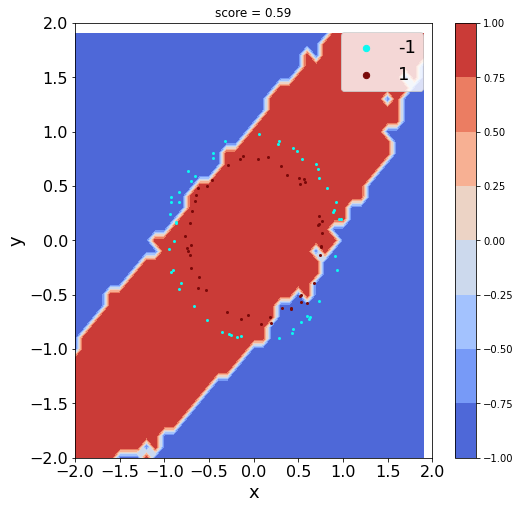

time :  11297.110495328903


In [39]:
N_DRAW=10000
q_fit(1, 1000)

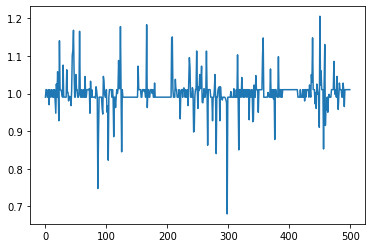

In [41]:
plt.plot([i for i in range(len(loss_list))], loss_list)

### Lunar data set

For lunar data set classification, we use two sources at the first two modes.

>>> Source distrbution


state,probability
"|1,1,1>",0.209585
"|0,1,1>",0.141134
"|1,0,1>",0.141134
"|1,1,0>",0.141134
"|0,0,1>",0.09504
"|0,1,0>",0.09504
"|1,0,0>",0.09504
"|0,0,0>",0.064
"|1,1,2>",0.002117
"|2,1,1>",0.002117


100%|██████████| 800/800 [00:23<00:00, 33.63it/s]


loss: 1.020401789048636


100%|██████████| 800/800 [00:22<00:00, 35.16it/s]


loss: 1.0202355778888819


100%|██████████| 800/800 [00:22<00:00, 36.18it/s]


loss: 0.9802987628115684


100%|██████████| 800/800 [00:22<00:00, 35.39it/s]


loss: 0.8353190207819036


100%|██████████| 800/800 [00:22<00:00, 36.00it/s]


loss: 1.0226661440525635


100%|██████████| 800/800 [00:21<00:00, 36.55it/s]


loss: 0.9802415733149462


100%|██████████| 800/800 [00:21<00:00, 36.93it/s]


loss: 1.0202747790297477


100%|██████████| 800/800 [00:22<00:00, 35.82it/s]


loss: 0.9802468937376547


100%|██████████| 800/800 [00:22<00:00, 34.81it/s]


loss: 1.0302377841816954


100%|██████████| 800/800 [00:22<00:00, 36.26it/s]


loss: 1.0203567048591473


100%|██████████| 800/800 [00:21<00:00, 37.09it/s]


loss: 0.980199097899851


100%|██████████| 800/800 [00:22<00:00, 36.21it/s]


loss: 0.9801824955232796


100%|██████████| 800/800 [00:22<00:00, 36.05it/s]


loss: 0.9803729417067475


100%|██████████| 800/800 [00:22<00:00, 34.79it/s]


loss: 0.9804918024759439


100%|██████████| 800/800 [00:22<00:00, 35.88it/s]


loss: 1.0202456145519483


100%|██████████| 800/800 [00:22<00:00, 35.98it/s]


loss: 1.0203001712715056


100%|██████████| 800/800 [00:22<00:00, 36.01it/s]


loss: 1.0201874268897009


100%|██████████| 800/800 [00:21<00:00, 36.43it/s]


loss: 0.9802167563109256


100%|██████████| 800/800 [00:21<00:00, 36.80it/s]


loss: 0.9802451198080941


100%|██████████| 800/800 [00:22<00:00, 35.39it/s]


loss: 1.1527629432009339


100%|██████████| 800/800 [00:22<00:00, 35.97it/s]


loss: 0.4553322486238634


100%|██████████| 800/800 [00:21<00:00, 36.58it/s]


loss: 0.9803320120346315


100%|██████████| 800/800 [00:22<00:00, 35.44it/s]


loss: 0.707889968854399


100%|██████████| 800/800 [00:22<00:00, 35.55it/s]


loss: 0.9802977809829828


100%|██████████| 800/800 [00:22<00:00, 35.80it/s]


loss: 0.49522919512508484


100%|██████████| 800/800 [00:22<00:00, 35.90it/s]


loss: 1.057899301127664


100%|██████████| 800/800 [00:22<00:00, 36.11it/s]


loss: 0.9801355884458212


100%|██████████| 800/800 [00:21<00:00, 36.51it/s]


loss: 0.9801355884458212


100%|██████████| 800/800 [00:22<00:00, 35.33it/s]


loss: 0.9801355884458212


100%|██████████| 800/800 [00:23<00:00, 34.77it/s]


loss: 0.9801355884458212


100%|██████████| 800/800 [00:23<00:00, 34.33it/s]


loss: 0.9801355884458212


100%|██████████| 800/800 [00:22<00:00, 35.44it/s]


loss: 0.9801355884458212


100%|██████████| 800/800 [00:22<00:00, 36.30it/s]


loss: 0.9801355884458212


100%|██████████| 800/800 [00:22<00:00, 35.98it/s]


loss: 0.9801355884458212


100%|██████████| 800/800 [00:22<00:00, 35.92it/s]


loss: 0.9801355884458212


100%|██████████| 800/800 [00:22<00:00, 36.14it/s]


loss: 0.9801355884458212


100%|██████████| 800/800 [00:21<00:00, 37.12it/s]


loss: 0.9801355884458212


100%|██████████| 800/800 [00:22<00:00, 36.36it/s]


loss: 0.9801355884458212


100%|██████████| 800/800 [00:22<00:00, 36.31it/s]


loss: 0.9801355884458212


100%|██████████| 800/800 [00:22<00:00, 35.77it/s]


loss: 0.9801355884458212


100%|██████████| 800/800 [00:21<00:00, 36.90it/s]


loss: 0.9801355884458212


100%|██████████| 800/800 [00:21<00:00, 36.43it/s]


loss: 0.9801355884458212


100%|██████████| 800/800 [00:22<00:00, 36.06it/s]


loss: 0.9801355884458212


100%|██████████| 800/800 [00:21<00:00, 36.82it/s]


loss: 0.9801355884458212


100%|██████████| 800/800 [00:22<00:00, 35.12it/s]


loss: 0.9801355884458212


100%|██████████| 800/800 [00:22<00:00, 36.34it/s]


loss: 0.9800510199088568


100%|██████████| 800/800 [00:22<00:00, 35.72it/s]


loss: 0.40013025844541766


100%|██████████| 800/800 [00:23<00:00, 34.70it/s]


loss: 0.6501202978373551


100%|██████████| 800/800 [00:22<00:00, 35.53it/s]


loss: 0.8926903579906124


100%|██████████| 800/800 [00:22<00:00, 35.76it/s]


loss: 0.9802207257292269


100%|██████████| 800/800 [00:21<00:00, 36.48it/s]


loss: 0.8702439507387338


100%|██████████| 800/800 [00:21<00:00, 36.41it/s]


loss: 0.98025763477231


100%|██████████| 800/800 [00:22<00:00, 35.38it/s]


loss: 0.9802922360360643


100%|██████████| 800/800 [00:21<00:00, 37.93it/s]


loss: 0.7353833509048613


100%|██████████| 800/800 [00:22<00:00, 35.98it/s]


loss: 1.0203813950446086


100%|██████████| 800/800 [00:23<00:00, 34.30it/s]


loss: 0.980309482193549


100%|██████████| 800/800 [00:22<00:00, 35.56it/s]


loss: 0.9727318887357549


100%|██████████| 800/800 [00:22<00:00, 36.13it/s]


loss: 1.020302395435764


100%|██████████| 800/800 [00:21<00:00, 36.86it/s]


loss: 1.0201894756949137


100%|██████████| 800/800 [00:22<00:00, 36.17it/s]


loss: 1.1302411503395386


100%|██████████| 800/800 [00:22<00:00, 36.11it/s]


loss: 1.020324864658323


100%|██████████| 800/800 [00:23<00:00, 34.58it/s]


loss: 1.0204945912725103


100%|██████████| 800/800 [00:22<00:00, 35.61it/s]


loss: 1.0201366035898258


100%|██████████| 800/800 [00:21<00:00, 36.38it/s]


loss: 1.0202345912598356


100%|██████████| 800/800 [00:21<00:00, 36.65it/s]


loss: 0.98019867056347


100%|██████████| 800/800 [00:22<00:00, 35.58it/s]


loss: 1.02026311741288


100%|██████████| 800/800 [00:22<00:00, 35.84it/s]


loss: 1.02020233479719


100%|██████████| 800/800 [00:22<00:00, 36.35it/s]


loss: 0.3477776646209329


100%|██████████| 800/800 [00:21<00:00, 36.78it/s]


loss: 0.98025411139778


100%|██████████| 800/800 [00:22<00:00, 35.29it/s]


loss: 1.0703039283527507


100%|██████████| 800/800 [00:22<00:00, 35.15it/s]


loss: 0.980299187306314


100%|██████████| 800/800 [00:22<00:00, 34.95it/s]


loss: 1.0202421125052665


100%|██████████| 800/800 [00:22<00:00, 35.11it/s]


loss: 0.9802674436697499


100%|██████████| 800/800 [00:22<00:00, 34.99it/s]


loss: 0.9803941452836351


100%|██████████| 800/800 [00:21<00:00, 37.79it/s]


loss: 1.0203664507202965


100%|██████████| 800/800 [00:21<00:00, 37.96it/s]


loss: 0.9803305129733443


100%|██████████| 800/800 [00:21<00:00, 37.73it/s]


loss: 1.020282990051696


100%|██████████| 800/800 [00:21<00:00, 36.90it/s]


loss: 1.0202404610381228


100%|██████████| 800/800 [00:22<00:00, 35.92it/s]


loss: 0.9802310501145742


100%|██████████| 800/800 [00:22<00:00, 35.25it/s]


loss: 0.9802310501145742


100%|██████████| 800/800 [00:22<00:00, 35.40it/s]


loss: 0.9802310501145742


100%|██████████| 800/800 [00:22<00:00, 36.24it/s]


loss: 0.9802310501145742


100%|██████████| 800/800 [00:22<00:00, 36.11it/s]


loss: 0.9802310501145742


100%|██████████| 800/800 [00:22<00:00, 35.28it/s]


loss: 0.9802310501145742


100%|██████████| 800/800 [00:22<00:00, 34.97it/s]


loss: 0.9802310501145742


100%|██████████| 800/800 [00:22<00:00, 35.13it/s]


loss: 0.9802310501145742


100%|██████████| 800/800 [00:21<00:00, 37.26it/s]


loss: 0.9802310501145742


100%|██████████| 800/800 [00:21<00:00, 37.78it/s]


loss: 0.9802310501145742


100%|██████████| 800/800 [00:21<00:00, 37.47it/s]


loss: 0.9802310501145742


100%|██████████| 800/800 [00:22<00:00, 35.73it/s]


loss: 0.9802310501145742


100%|██████████| 800/800 [00:22<00:00, 35.24it/s]


loss: 0.9802310501145742


100%|██████████| 800/800 [00:22<00:00, 34.78it/s]


loss: 0.9802310501145742


100%|██████████| 800/800 [00:22<00:00, 34.85it/s]


loss: 0.9802310501145742


100%|██████████| 800/800 [00:23<00:00, 34.43it/s]


loss: 0.9802310501145742


100%|██████████| 800/800 [00:22<00:00, 35.92it/s]


loss: 0.9802310501145742


100%|██████████| 800/800 [00:22<00:00, 35.74it/s]


loss: 0.9802310501145742


100%|██████████| 800/800 [00:22<00:00, 36.05it/s]


loss: 0.9802310501145742


100%|██████████| 800/800 [00:22<00:00, 36.05it/s]


loss: 0.9802102152828814


100%|██████████| 800/800 [00:21<00:00, 37.25it/s]


loss: 0.955195247352627


100%|██████████| 800/800 [00:21<00:00, 36.74it/s]


loss: 0.4301473981149787


100%|██████████| 800/800 [00:21<00:00, 36.98it/s]


loss: 0.4051445503703757


100%|██████████| 800/800 [00:21<00:00, 36.93it/s]


loss: 1.020112892763317


100%|██████████| 800/800 [00:21<00:00, 36.71it/s]


loss: 1.0201699567426947


100%|██████████| 800/800 [00:22<00:00, 35.48it/s]


loss: 1.0202674538824388


100%|██████████| 800/800 [00:21<00:00, 36.52it/s]


loss: 1.0201856838120997


100%|██████████| 800/800 [00:21<00:00, 37.67it/s]


loss: 1.4904452218860627


100%|██████████| 800/800 [00:21<00:00, 37.81it/s]


loss: 1.0202266257480972


100%|██████████| 800/800 [00:21<00:00, 37.58it/s]


loss: 0.9802792365238475


100%|██████████| 800/800 [00:22<00:00, 35.91it/s]


loss: 1.0152172943324105


100%|██████████| 800/800 [00:20<00:00, 38.13it/s]


loss: 1.475489346834476


100%|██████████| 800/800 [00:21<00:00, 37.63it/s]


loss: 0.9801154156932892


100%|██████████| 800/800 [00:20<00:00, 38.18it/s]


loss: 1.1127951273455987


100%|██████████| 800/800 [00:20<00:00, 38.51it/s]


loss: 1.0202479882039572


100%|██████████| 800/800 [00:20<00:00, 38.53it/s]


loss: 0.9801741464098437


100%|██████████| 800/800 [00:20<00:00, 38.36it/s]


loss: 0.9802441894543563


100%|██████████| 800/800 [00:21<00:00, 37.43it/s]


loss: 1.020267552539172


100%|██████████| 800/800 [00:21<00:00, 36.37it/s]


loss: 0.97521110513814


100%|██████████| 800/800 [00:21<00:00, 36.89it/s]


loss: 0.9803278371051877


100%|██████████| 800/800 [00:22<00:00, 36.01it/s]


loss: 0.9928088284555994


100%|██████████| 800/800 [00:23<00:00, 34.49it/s]


loss: 0.9802795865679154


100%|██████████| 800/800 [00:21<00:00, 37.06it/s]


loss: 0.6353697391378561


100%|██████████| 800/800 [00:20<00:00, 38.14it/s]


loss: 0.9803179548088821


100%|██████████| 800/800 [00:21<00:00, 37.30it/s]


loss: 1.0627778356670625


100%|██████████| 800/800 [00:23<00:00, 34.30it/s]


loss: 0.6751655881879053


100%|██████████| 800/800 [00:22<00:00, 34.96it/s]


loss: 0.9801651498624487


100%|██████████| 800/800 [00:21<00:00, 37.34it/s]


loss: 1.0128761728299225


100%|██████████| 800/800 [00:22<00:00, 35.15it/s]


loss: 1.0202841361067625


100%|██████████| 800/800 [00:23<00:00, 34.42it/s]


loss: 1.172836343128523


100%|██████████| 800/800 [00:22<00:00, 36.00it/s]


loss: 1.2103363431285228


100%|██████████| 800/800 [00:21<00:00, 37.48it/s]


loss: 1.350336343128523


100%|██████████| 800/800 [00:21<00:00, 38.02it/s]


loss: 0.910336343128523


100%|██████████| 800/800 [00:21<00:00, 37.68it/s]


loss: 0.550336343128523


100%|██████████| 800/800 [00:21<00:00, 37.30it/s]


loss: 0.9803363431285229


100%|██████████| 800/800 [00:21<00:00, 37.33it/s]


loss: 0.9803363431285229


100%|██████████| 800/800 [00:22<00:00, 35.48it/s]


loss: 1.3953363431285228


100%|██████████| 800/800 [00:22<00:00, 35.08it/s]


loss: 1.1353363431285228


100%|██████████| 800/800 [00:22<00:00, 34.92it/s]


loss: 1.017836343128523


100%|██████████| 800/800 [00:22<00:00, 34.92it/s]


loss: 0.977836343128523


100%|██████████| 800/800 [00:23<00:00, 33.89it/s]


loss: 1.0203363431285228


100%|██████████| 800/800 [00:21<00:00, 36.63it/s]


loss: 0.9853363431285229


100%|██████████| 800/800 [00:21<00:00, 37.55it/s]


loss: 1.0203363431285228


100%|██████████| 800/800 [00:21<00:00, 37.71it/s]


loss: 0.890336343128523


100%|██████████| 800/800 [00:21<00:00, 36.99it/s]


loss: 1.3628363431285229


100%|██████████| 800/800 [00:22<00:00, 36.00it/s]


loss: 1.100336343128523


100%|██████████| 800/800 [00:22<00:00, 36.17it/s]


loss: 1.1053363431285228


100%|██████████| 800/800 [00:22<00:00, 36.04it/s]


loss: 0.8028363431285229


100%|██████████| 800/800 [00:22<00:00, 36.03it/s]


loss: 0.8253638236138952


100%|██████████| 800/800 [00:22<00:00, 35.95it/s]


loss: 0.9778134448247452


100%|██████████| 800/800 [00:22<00:00, 35.16it/s]


loss: 0.9627853132771207


100%|██████████| 800/800 [00:22<00:00, 36.01it/s]


loss: 0.995321370727632


100%|██████████| 800/800 [00:22<00:00, 36.32it/s]


loss: 0.8378262408586625


100%|██████████| 800/800 [00:22<00:00, 36.02it/s]


loss: 1.0128377960376422


100%|██████████| 800/800 [00:22<00:00, 35.18it/s]


loss: 0.9878387202400909


100%|██████████| 800/800 [00:20<00:00, 38.12it/s]


loss: 0.9803032980927983


100%|██████████| 800/800 [00:20<00:00, 38.26it/s]


loss: 0.82789242325068


100%|██████████| 800/800 [00:20<00:00, 38.40it/s]


loss: 1.020087096795964


100%|██████████| 800/800 [00:21<00:00, 37.30it/s]


loss: 0.980184725296244


100%|██████████| 800/800 [00:22<00:00, 35.97it/s]


loss: 0.9803302497355201


100%|██████████| 800/800 [00:23<00:00, 34.50it/s]


loss: 1.0526308392792088


100%|██████████| 800/800 [00:21<00:00, 37.09it/s]


loss: 1.1328808596658586


100%|██████████| 800/800 [00:20<00:00, 38.43it/s]


loss: 1.0202644678601442


100%|██████████| 800/800 [00:20<00:00, 38.17it/s]


loss: 1.077709694987426


100%|██████████| 800/800 [00:21<00:00, 37.09it/s]


loss: 1.0203264214777281


100%|██████████| 800/800 [00:21<00:00, 36.74it/s]


loss: 0.9802393491774966


100%|██████████| 800/800 [00:22<00:00, 36.18it/s]


loss: 0.9803868300001687


100%|██████████| 800/800 [00:21<00:00, 37.85it/s]


loss: 0.9802568222840413


100%|██████████| 800/800 [00:22<00:00, 34.98it/s]


loss: 1.0327777699286786


100%|██████████| 800/800 [00:23<00:00, 34.28it/s]


loss: 1.0201863717911142


100%|██████████| 800/800 [00:23<00:00, 34.78it/s]


loss: 1.020247775315227


100%|██████████| 800/800 [00:22<00:00, 34.86it/s]


loss: 0.9801946267897922


100%|██████████| 800/800 [00:23<00:00, 34.77it/s]


loss: 1.0201718697425088


100%|██████████| 800/800 [00:22<00:00, 35.20it/s]


loss: 0.9601788763338177


100%|██████████| 800/800 [00:21<00:00, 37.00it/s]


loss: 1.020237315068093


100%|██████████| 800/800 [00:21<00:00, 36.62it/s]


loss: 1.0201638333120455


100%|██████████| 800/800 [00:22<00:00, 34.94it/s]


loss: 0.9952532878528989


100%|██████████| 800/800 [00:23<00:00, 34.15it/s]


loss: 0.9801221920862542


100%|██████████| 800/800 [00:23<00:00, 33.89it/s]


loss: 1.020344584492712


100%|██████████| 800/800 [00:23<00:00, 34.65it/s]


loss: 1.1627439098332768


100%|██████████| 800/800 [00:22<00:00, 34.80it/s]


loss: 1.0203492708386563


100%|██████████| 800/800 [00:21<00:00, 37.31it/s]


loss: 0.9804560652301219


100%|██████████| 800/800 [00:23<00:00, 34.14it/s]


loss: 0.9804560652301219


100%|██████████| 800/800 [00:23<00:00, 34.22it/s]


loss: 0.9804560652301219


100%|██████████| 800/800 [00:22<00:00, 35.97it/s]


loss: 0.9804560652301219


100%|██████████| 800/800 [00:21<00:00, 37.35it/s]


loss: 0.9804560652301219


100%|██████████| 800/800 [00:21<00:00, 37.08it/s]


loss: 0.9804560652301219


100%|██████████| 800/800 [00:21<00:00, 37.38it/s]


loss: 0.9804560652301219


100%|██████████| 800/800 [00:21<00:00, 36.81it/s]


loss: 0.9804560652301219


100%|██████████| 800/800 [00:21<00:00, 36.81it/s]


loss: 0.9804560652301219


100%|██████████| 800/800 [00:22<00:00, 35.48it/s]


loss: 0.9804560652301219


100%|██████████| 800/800 [00:23<00:00, 34.07it/s]


loss: 0.9804560652301219


100%|██████████| 800/800 [00:21<00:00, 37.55it/s]


loss: 0.9804560652301219


100%|██████████| 800/800 [00:21<00:00, 37.67it/s]


loss: 0.9804560652301219


100%|██████████| 800/800 [00:21<00:00, 37.67it/s]


loss: 0.9804560652301219


100%|██████████| 800/800 [00:21<00:00, 36.56it/s]


loss: 0.9804560652301219


100%|██████████| 800/800 [00:22<00:00, 36.25it/s]


loss: 0.9804560652301219


100%|██████████| 800/800 [00:21<00:00, 36.37it/s]


loss: 0.9804560652301219


100%|██████████| 800/800 [00:21<00:00, 36.39it/s]


loss: 0.9804560652301219


100%|██████████| 800/800 [00:21<00:00, 36.42it/s]


loss: 0.9804560652301219


100%|██████████| 800/800 [00:22<00:00, 36.27it/s]


loss: 0.980430768902705


100%|██████████| 800/800 [00:21<00:00, 36.72it/s]


loss: 0.9803874149722331


100%|██████████| 800/800 [00:21<00:00, 37.00it/s]


loss: 0.9803371345115423


100%|██████████| 800/800 [00:21<00:00, 37.29it/s]


loss: 0.9802522325577454


100%|██████████| 800/800 [00:22<00:00, 36.03it/s]


loss: 1.2177704761539518


100%|██████████| 800/800 [00:21<00:00, 36.96it/s]


loss: 1.1302844822938907


100%|██████████| 800/800 [00:21<00:00, 37.13it/s]


loss: 1.0202407673862972


100%|██████████| 800/800 [00:21<00:00, 36.70it/s]


loss: 0.9801625852309787


100%|██████████| 800/800 [00:21<00:00, 36.80it/s]


loss: 0.980259330178757


100%|██████████| 800/800 [00:21<00:00, 37.23it/s]


loss: 0.9803164037493426


100%|██████████| 800/800 [00:21<00:00, 37.09it/s]


loss: 0.9801098898269273


100%|██████████| 800/800 [00:21<00:00, 37.14it/s]


loss: 1.0729413070133753


100%|██████████| 800/800 [00:21<00:00, 37.32it/s]


loss: 0.8729348093557271


100%|██████████| 800/800 [00:21<00:00, 37.14it/s]


loss: 0.9802626864247438


100%|██████████| 800/800 [00:21<00:00, 37.28it/s]


loss: 1.0226931810126083


100%|██████████| 800/800 [00:21<00:00, 36.70it/s]


loss: 1.020271827884079


100%|██████████| 800/800 [00:21<00:00, 37.53it/s]


loss: 1.0202184588111038


100%|██████████| 800/800 [00:21<00:00, 36.89it/s]


loss: 0.9803121862462694


100%|██████████| 800/800 [00:23<00:00, 33.71it/s]


loss: 1.0202763551231526


100%|██████████| 800/800 [00:21<00:00, 37.99it/s]


loss: 0.980314413978913


100%|██████████| 800/800 [00:20<00:00, 38.30it/s]


loss: 1.0202135773662189


100%|██████████| 800/800 [00:22<00:00, 35.44it/s]


loss: 0.6929253078111878


100%|██████████| 800/800 [00:22<00:00, 35.76it/s]


loss: 1.6052802179141503


100%|██████████| 800/800 [00:21<00:00, 38.00it/s]


loss: 1.020341748685143


100%|██████████| 800/800 [00:20<00:00, 38.34it/s]


loss: 0.9802164966491919


100%|██████████| 800/800 [00:21<00:00, 38.04it/s]


loss: 1.0802110793781494


100%|██████████| 800/800 [00:20<00:00, 38.10it/s]


loss: 0.9802785338118452


100%|██████████| 800/800 [00:21<00:00, 38.07it/s]


loss: 1.580215037444252


100%|██████████| 800/800 [00:21<00:00, 36.95it/s]


loss: 0.9801806117807463


100%|██████████| 800/800 [00:21<00:00, 36.98it/s]


loss: 1.0203813640987855


100%|██████████| 800/800 [00:22<00:00, 35.94it/s]


loss: 1.0027811002124005


100%|██████████| 800/800 [00:23<00:00, 34.76it/s]


loss: 1.422825229023005


100%|██████████| 800/800 [00:23<00:00, 34.21it/s]


loss: 1.2052822890633135


100%|██████████| 800/800 [00:23<00:00, 34.30it/s]


loss: 0.9802481304235493


100%|██████████| 800/800 [00:21<00:00, 36.92it/s]


loss: 0.9802481304235493


100%|██████████| 800/800 [00:21<00:00, 37.16it/s]


loss: 0.9802481304235493


100%|██████████| 800/800 [00:21<00:00, 37.91it/s]


loss: 0.9802481304235493


100%|██████████| 800/800 [00:21<00:00, 37.68it/s]


loss: 0.9802481304235493


100%|██████████| 800/800 [00:21<00:00, 37.81it/s]


loss: 0.9802481304235493


100%|██████████| 800/800 [00:21<00:00, 37.78it/s]


loss: 0.9802481304235493


100%|██████████| 800/800 [00:21<00:00, 37.84it/s]


loss: 0.9802481304235493


100%|██████████| 800/800 [00:21<00:00, 37.69it/s]


loss: 0.9802481304235493


100%|██████████| 800/800 [00:20<00:00, 38.40it/s]


loss: 0.9802481304235493


100%|██████████| 800/800 [00:21<00:00, 36.88it/s]


loss: 0.9802481304235493


100%|██████████| 800/800 [00:21<00:00, 36.71it/s]


loss: 0.9802481304235493


100%|██████████| 800/800 [00:21<00:00, 36.74it/s]


loss: 0.9802481304235493


100%|██████████| 800/800 [00:22<00:00, 35.15it/s]


loss: 0.9802481304235493


100%|██████████| 800/800 [00:21<00:00, 36.84it/s]


loss: 0.9802481304235493


100%|██████████| 800/800 [00:22<00:00, 35.47it/s]


loss: 0.9802481304235493
 Run  Iter     Obj       Grad     Delta      rho     Evals 
  1     1   -8.20e-01  1.09e+00  1.00e-01  1.00e-01    9   
  1     2   -8.50e-01  1.59e-01  1.00e-01  1.00e-01   10   
  1     3   -8.50e-01  4.36e-01  5.00e-02  1.00e-02   11   
  1     4   -8.60e-01  2.28e-01  5.00e-02  1.00e-02   12   
  1     5   -8.60e-01  9.43e-01  2.50e-02  1.00e-02   14   
  1     6   -8.70e-01  1.51e+00  1.00e-02  1.00e-02   16   
  1     7   -8.70e-01  4.25e+00  1.00e-02  1.00e-02   18   
  1     8   -8.70e-01  2.67e+00  5.00e-03  1.00e-03   19   
  1     9   -8.70e-01  6.90e+00  2.50e-03  1.00e-03   21   
  1    10   -8.70e-01  2.75e+01  1.00e-03  1.00e-03   23   
  1    11   -8.70e-01  7.91e+01  5.00e-04  1.00e-04   24   
  1    12   -8.70e-01  1.75e+02  2.50e-04  1.00e-04   26   
  1    13   -8.70e-01  9.81e+01  1.00e-04  1.00e-04   28   
  1    14   -8.70e-01  1.11e+02  1.00e-04  1.00e-04   30   
  1    15   -8.70e-01  3.01e+02  1.00e-04  1.00e-04   32   
  1    16   -8.

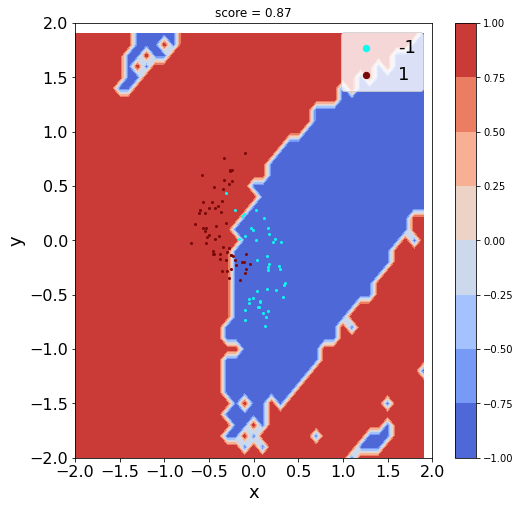

time :  5746.08390378952


In [29]:
N_DRAW=1000
q_fit(2, 1000)

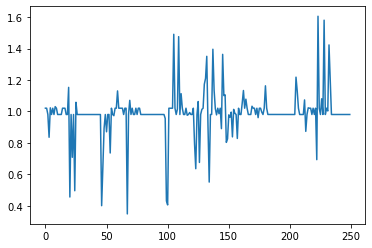

In [30]:
plt.plot([i for i in range(len(loss_list))], loss_list)